In [8]:
# tf.train.Example
import tensorflow as tf
import numpy as np

In [9]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


In [13]:
def serialize_example(feature_image, feature_label):
    feature = {
        "image": _bytes_feature(feature_image),
        "label": _int64_feature(feature_label),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

test1 = serialize_example(b"human", 6)
test1

b'\n$\n\x12\n\x05image\x12\t\n\x07\n\x05human\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\x06'

In [22]:
def deserialize_example(serialized_example):
    return tf.train.Example.FromString(serialized_example)

#test2 = deserialize_example(test1)
#test2

In [78]:
## tf.train.Example vs TFRecords
import os
base_dir = "/home/lidavid/data/tensorflow_datasets/cifar10_1/v4/"
cifar_dir="1.1.0/"
tf_record = os.path.join(base_dir + cifar_dir + "cifar10_1-test.tfrecord-00000-of-00001")
raw_dataset = tf.data.TFRecordDataset(tf_record)

In [72]:
# iterat through dataset 

#raw2 = list(raw_dataset.as_numpy_iterator())

#sub1 = raw_dataset.take(2)
#list(sub1.as_numpy_iterator())



In [34]:
raw_example = next(iter(raw_dataset))
parsed_example = deserialize_example(raw_example.numpy())  #ND array is an alias to `tf.Tensor`


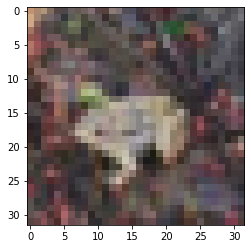

In [35]:
import matplotlib.pyplot as plt
def decode_cifar_image(parsed_example):
    raw_img = parsed_example.features.feature["image"].bytes_list.value[0]
    img = tf.image.decode_png(raw_img)
    plt.imshow(img)

decode_cifar_image(parsed_example)

In [142]:
#at this point, datast contains serialized `tf.train.Example` messages

feature_description = {
    "image": tf.io.FixedLenFeature([], dtype=tf.string) ,
    "label": tf.io.FixedLenFeature([], dtype=tf.int64),
}

def _single_parse(eg):
    return tf.io.parse_single_example(eg, feature_description)

def _parse(eg):
    example = tf.io.parse_example(eg, feature_description)
    return example

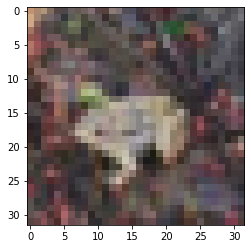

In [143]:
raw_img =  _single_parse(raw_example)   #image in bytes
img = tf.image.decode_png(raw_img["image"])
plt.imshow(img)

In [170]:
subset= raw_dataset.take(4)
from collections import defaultdict

label_count = defaultdict(int)
img_path = base_dir + "images/"  #need first have this folder

def image_save(raw):
    img = tf.image.decode_png(raw["image"])
    #TODO: 
    if isinstance(raw["label"], np.int64):
        label = raw["label"]
    else:
        label = raw["label"].numpy()
    if label in label_count:
        label_count[label] += 1 
    else:
        label_count[label] = 1
    img_name = "%02d_%04d.jpeg"%(label, label_count[label])
    plt.imshow(img)
    plt.savefig(os.path.join(img_path, img_name), format='jpg')


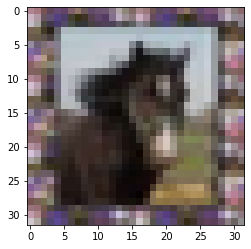

In [171]:
decoded_subset = subset.map(_parse)

for ele in decoded_subset.as_numpy_iterator():
    image_save(ele)

In [175]:
# write to TFRecords
writer = tf.io.TFRecordWriter(os.path.join(img_path, "cifar_10.tfrecord"))
for filename in os.listdir(img_path):
    if filename.lower().endswith("jpeg"):
        image_label = int(filename[:2])
        image_bytes = open(os.path.join(img_path, filename), 'rb').read()
        encoded_ = serialize_example(image_bytes, image_label)
        writer.write(encoded_)